In [3]:
import torch
from typing import Union, List
from transformers import AutoTokenizer, AutoModelForTextEncoding
import seaborn as sns
import matplotlib.pyplot as plt

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
tokenizer = AutoTokenizer.from_pretrained("kaiyuy/leandojo-lean4-retriever-byt5-small")
model = AutoModelForTextEncoding.from_pretrained("kaiyuy/leandojo-lean4-retriever-byt5-small")

state = "n : ℕ\n⊢ gcd n n = n"
premises = [
  "<a>vsub_eq_zero_iff_eq</a> @[simp] lemma vsub_eq_zero_iff_eq {p1 p2 : P} : p1 -ᵥ p2 = (0 : G) ↔ p1 = p2",
  "<a>is_scalar_tower.coe_to_alg_hom'</a> @[simp] lemma coe_to_alg_hom' : (to_alg_hom R S A : S → A) = algebra_map S A",
  "<a>polynomial.X_sub_C_ne_zero</a> theorem X_sub_C_ne_zero (r : R) : X - C r ≠ 0",
  "<a>forall_true_iff</a> theorem forall_true_iff : (α → true) ↔ true",
  "def <a>Nat.gcd</a> : Nat → Nat → Nat\n| 0        y := y\n| (succ x) y := have y % succ x < succ x, from mod_lt _ $ succ_pos _,\n                gcd (y % succ x) (succ x)",
  "@[simp] theorem <a>Nat.gcd_zero_left</a> (x : Nat) : gcd 0 x = x",
  "@[simp] theorem <a>Nat.gcd_succ</a> (x y : Nat) : gcd (succ x) y = gcd (y % succ x) (succ x)",
  "@[simp] theorem <a>Nat.mod_self</a> (n : Nat) : n % n = 0",
]  # A corpus of premises to retrieve from.

@torch.no_grad()
def encode(s: Union[str, List[str]]) -> torch.Tensor:
    """Encode texts into feature vectors."""
    if isinstance(s, str):
        s = [s]
        should_squeeze = True
    else:
        should_squeeze = False
    tokenized_s = tokenizer(s, return_tensors="pt", padding=True)
    hidden_state = model(tokenized_s.input_ids).last_hidden_state
    lens = tokenized_s.attention_mask.sum(dim=1)
    features = (hidden_state * tokenized_s.attention_mask.unsqueeze(2)).sum(dim=1) / lens.unsqueeze(1)
    if should_squeeze:
      features = features.squeeze()
    return features

@torch.no_grad()
def retrieve(state: str, premises: List[str], k: int) -> List[str]:
    """Retrieve the top-k premises given a state."""
    state_emb = encode(state)
    premise_embs = encode(premises)
    scores = (state_emb @ premise_embs.T)
    topk = scores.topk(k).indices.tolist()
    return [premises[i] for i in topk]

for p in retrieve(state, premises, k=4):
    print(p, end="\n\n")

def <a>Nat.gcd</a> : Nat → Nat → Nat
| 0        y := y
| (succ x) y := have y % succ x < succ x, from mod_lt _ $ succ_pos _,
                gcd (y % succ x) (succ x)

@[simp] theorem <a>Nat.gcd_zero_left</a> (x : Nat) : gcd 0 x = x

@[simp] theorem <a>Nat.gcd_succ</a> (x y : Nat) : gcd (succ x) y = gcd (y % succ x) (succ x)

@[simp] theorem <a>Nat.mod_self</a> (n : Nat) : n % n = 0



In [5]:
tactic_state = """a r : ℝ
u : ℕ → ℝ
h₀ : ∀ (k : ℕ), u k = a * r ^ k
h₁ : a * r ^ 1 = 2
h₂ : a * r ^ 3 = 6
⊢ a * r ^ 0 = 2 / √3 ∨ a * r ^ 0 = -(2 / √3)
"""

In [6]:
ts_embed = encode(tactic_state)
print(ts_embed)

tensor([-0.0008, -0.0012,  0.0407,  ...,  0.0908,  0.0793,  0.0084])


In [7]:
ts_embed.shape

torch.Size([1472])

In [8]:
sim = [[(encode(premises[i]) @ encode(premises[j]).T).item() for j in range(len(premises))] for i in range(len(premises))]
sim

/tmp/ipykernel_226479/779277539.py:1: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3697.)
  sim = [[(encode(premises[i]) @ encode(premises[j]).T).item() for j in range(len(premises))] for i in range(len(premises))]


[[7.770539283752441,
  -0.06689333915710449,
  0.2893684506416321,
  -0.3152797222137451,
  0.056034334003925323,
  0.009736567735671997,
  -0.036080025136470795,
  0.11008135974407196],
 [-0.06689333915710449,
  3.818486213684082,
  -0.1154407411813736,
  0.03199087083339691,
  0.032668426632881165,
  -0.0821375697851181,
  0.027546245604753494,
  -0.089018315076828],
 [0.2893684506416321,
  -0.1154407411813736,
  4.492486953735352,
  -0.2709200978279114,
  -0.13376197218894958,
  -0.17646880447864532,
  -0.11022764444351196,
  -0.1242537647485733],
 [-0.3152797222137451,
  0.03199087083339691,
  -0.2709200978279114,
  8.39046859741211,
  -0.03169233351945877,
  -0.2204798012971878,
  -0.05510476231575012,
  -0.06887281686067581],
 [0.056034334003925323,
  0.032668426632881165,
  -0.13376197218894958,
  -0.03169233351945877,
  4.199517250061035,
  2.778473138809204,
  3.253335952758789,
  0.19579441845417023],
 [0.009736567735671997,
  -0.0821375697851181,
  -0.17646880447864532,
  -0

In [9]:
pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


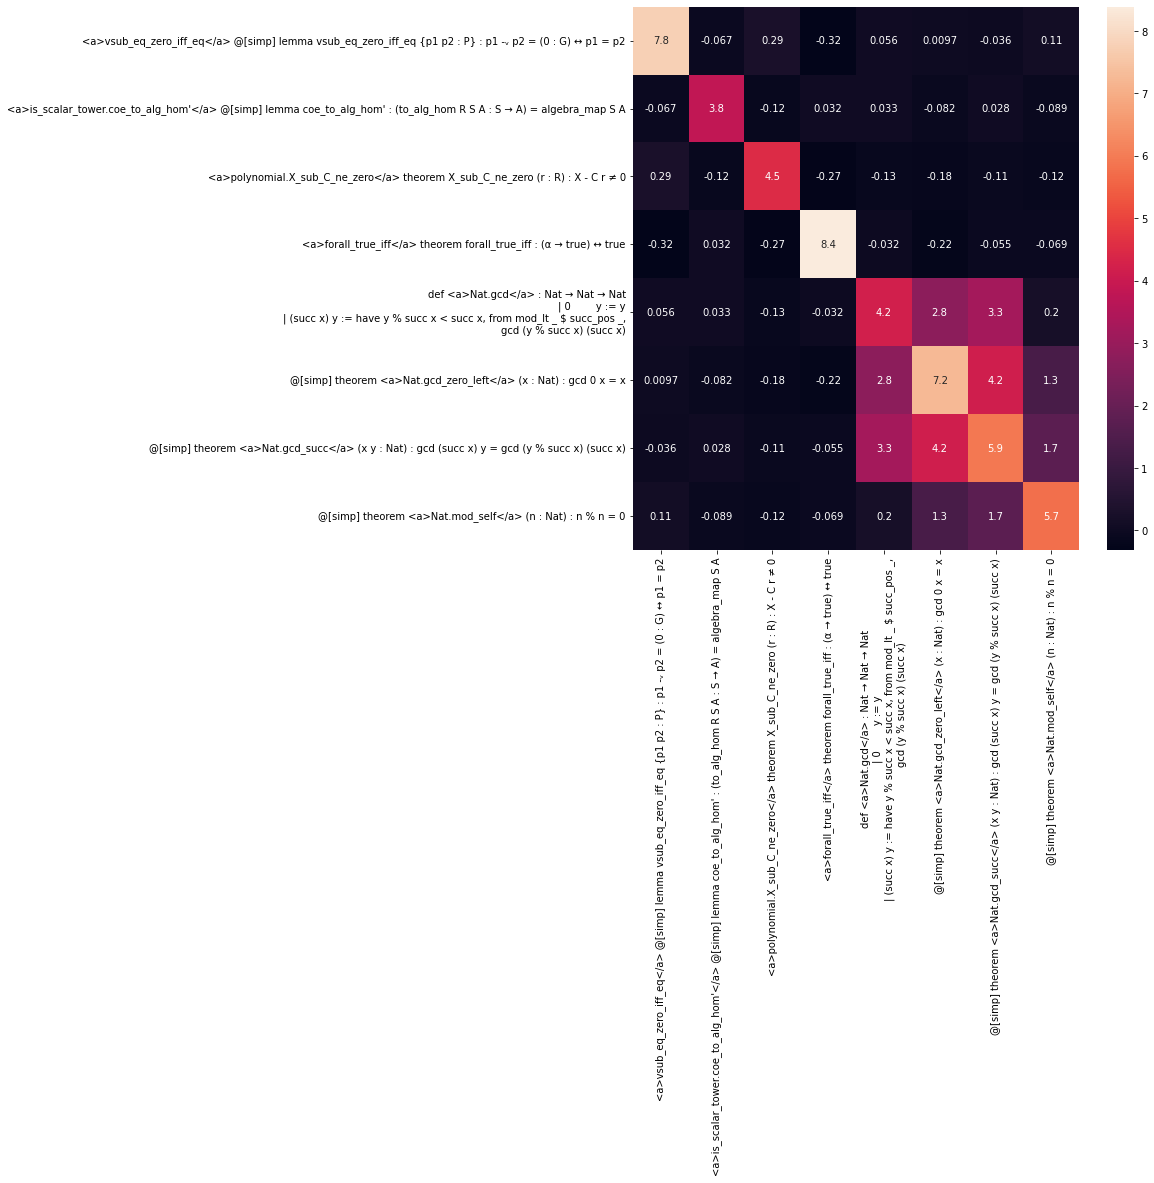

In [10]:
plt.figure(figsize=(10, 10))
sns.heatmap(sim, annot=True, xticklabels=premises, yticklabels=premises)
plt.show()

In [11]:
tactic_states = [
    """a r : ℝ
    u : ℕ → ℝ
    h₀ : ∀ (k : ℕ), u k = a * r ^ k
    h₁ : a * r ^ 1 = 2
    h₂ : a * r ^ 3 = 6
    ⊢ a * r ^ 0 = 2 / √3 ∨ a * r ^ 0 = -(2 / √3)
    """,
    """a b : ℝ
    h₀ : logb 8 a + logb 4 (b ^ 2) = 5
    h₁ : logb 8 b + logb 4 (a ^ 2) = 7
    ⊢ a * b = 512
    """,
    """
    x y : ℝ
    h₀ : logb 8 x + logb 4 (y ^ 2) = 5
    h₁ : logb 8 y + logb 4 (x ^ 2) = 7
    ⊢ x * y = 512
    """,
    """⊢ (3 / 8 + 7 / 8) / (4 / 5) = 25 / 16"""
]

In [14]:
ts_embeds = [encode(ts) for ts in tactic_states]

In [15]:
ts_sim = [[(ts_embeds[i] @ ts_embeds[j].T).item() for j in range(len(tactic_states))] for i in range(len(tactic_states))]

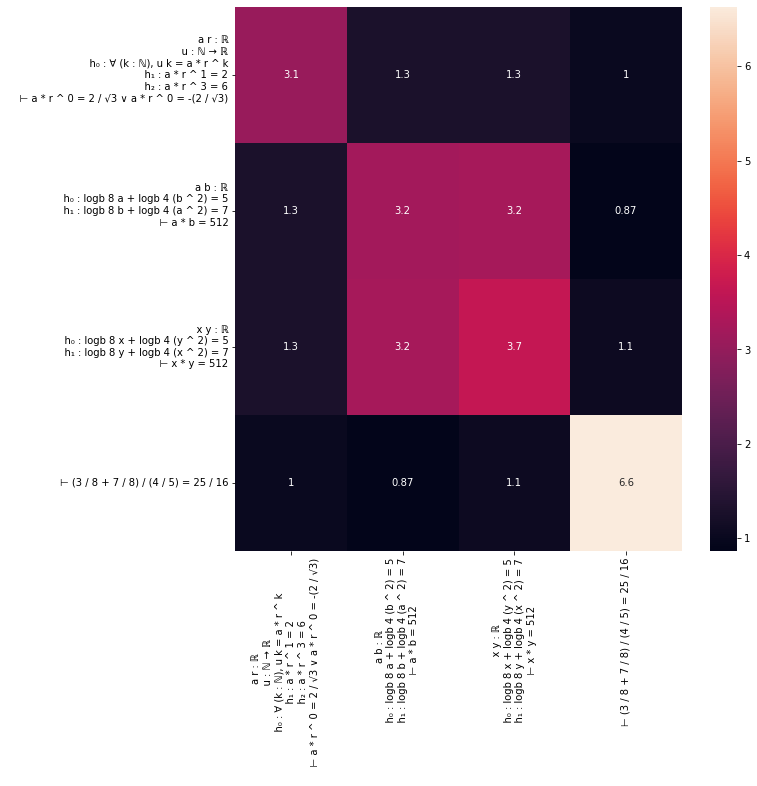

In [17]:
plt.figure(figsize=(10, 10))
sns.heatmap(ts_sim, annot=True, xticklabels=tactic_states, yticklabels=tactic_states)
plt.show()

In [18]:
normalized_ts_embeds = torch.nn.functional.normalize(torch.stack(ts_embeds))
normalized_ts_sim = [[(normalized_ts_embeds[i] @ normalized_ts_embeds[j].T).item() for j in range(len(tactic_states))] for i in range(len(tactic_states))]

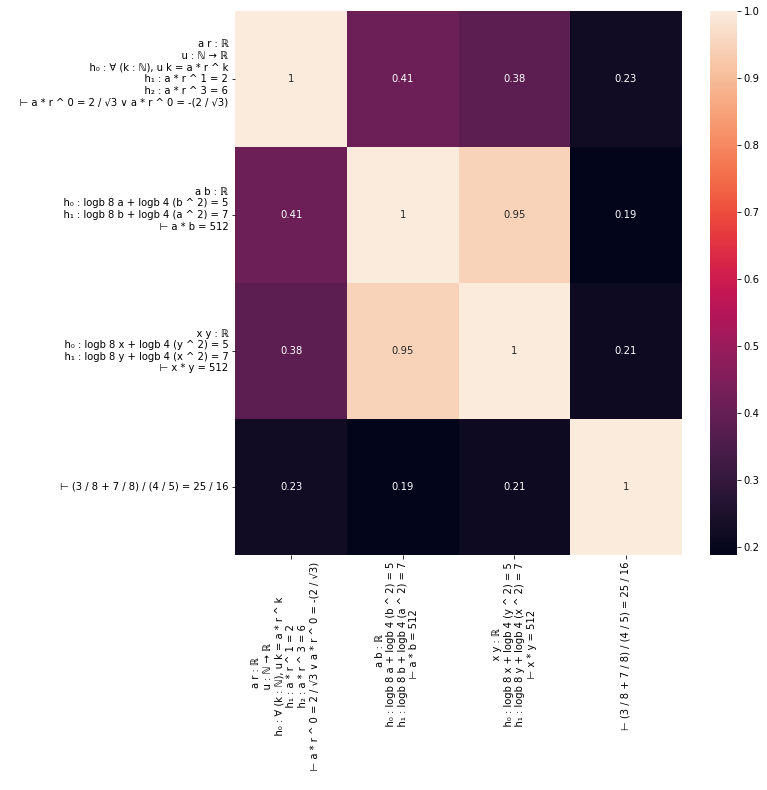

In [19]:
plt.figure(figsize=(10, 10))
sns.heatmap(normalized_ts_sim, annot=True, xticklabels=tactic_states, yticklabels=tactic_states)
plt.show()

In [23]:
ts_all = tactic_states + [
    """S : Finset ℕ
    h₀ : ∀ (n : ℕ), n ∈ S ↔ √↑n < 7 / 2 ∧ 2 < √↑n
    ⊢ S = {4, 5, 6, 7, 8, 9, 10, 11}
    """,
    """p q r x : ℂ
    h₀ : (x - p) * (x - q) = (r - p) * (r - q)
    h₁ : x ≠ r
    ⊢ x = p + q - r
    """,
    """case zero
    a : ℕ → NNReal
    h₀ : (Finset.range 0).prod a = 1
    ⊢ (Finset.range 0).sum a ≥ ↑0

    case succ
    a : ℕ → NNReal
    n : ℕ
    hn : (Finset.range n).prod a = 1 → (Finset.range n).sum a ≥ ↑n
    h₀ : (Finset.range (n + 1)).prod a = 1
    ⊢ (Finset.range (n + 1)).sum a ≥ ↑(n + 1)
    """,
    """x : ℕ
    h₀ : 1 ≤ x ∧ x ≤ 100
    h₁ : 77 ∣ 5050 - x
    ⊢ x = 45
    """,
    """x : ℕ
    h₀ : 1 ≤ x ∧ x ≤ 100
    h₁ : (5050 - x) % 77 = 0
    ⊢ x = 45
    """
]

In [24]:
all_ts_embeds = [encode(ts) for ts in ts_all]
normalized_all_ts_embeds = torch.nn.functional.normalize(torch.stack(all_ts_embeds))
normalized_all_ts_sim = [[(normalized_all_ts_embeds[i] @ normalized_all_ts_embeds[j].T).item() for j in range(len(ts_all))] for i in range(len(ts_all))]

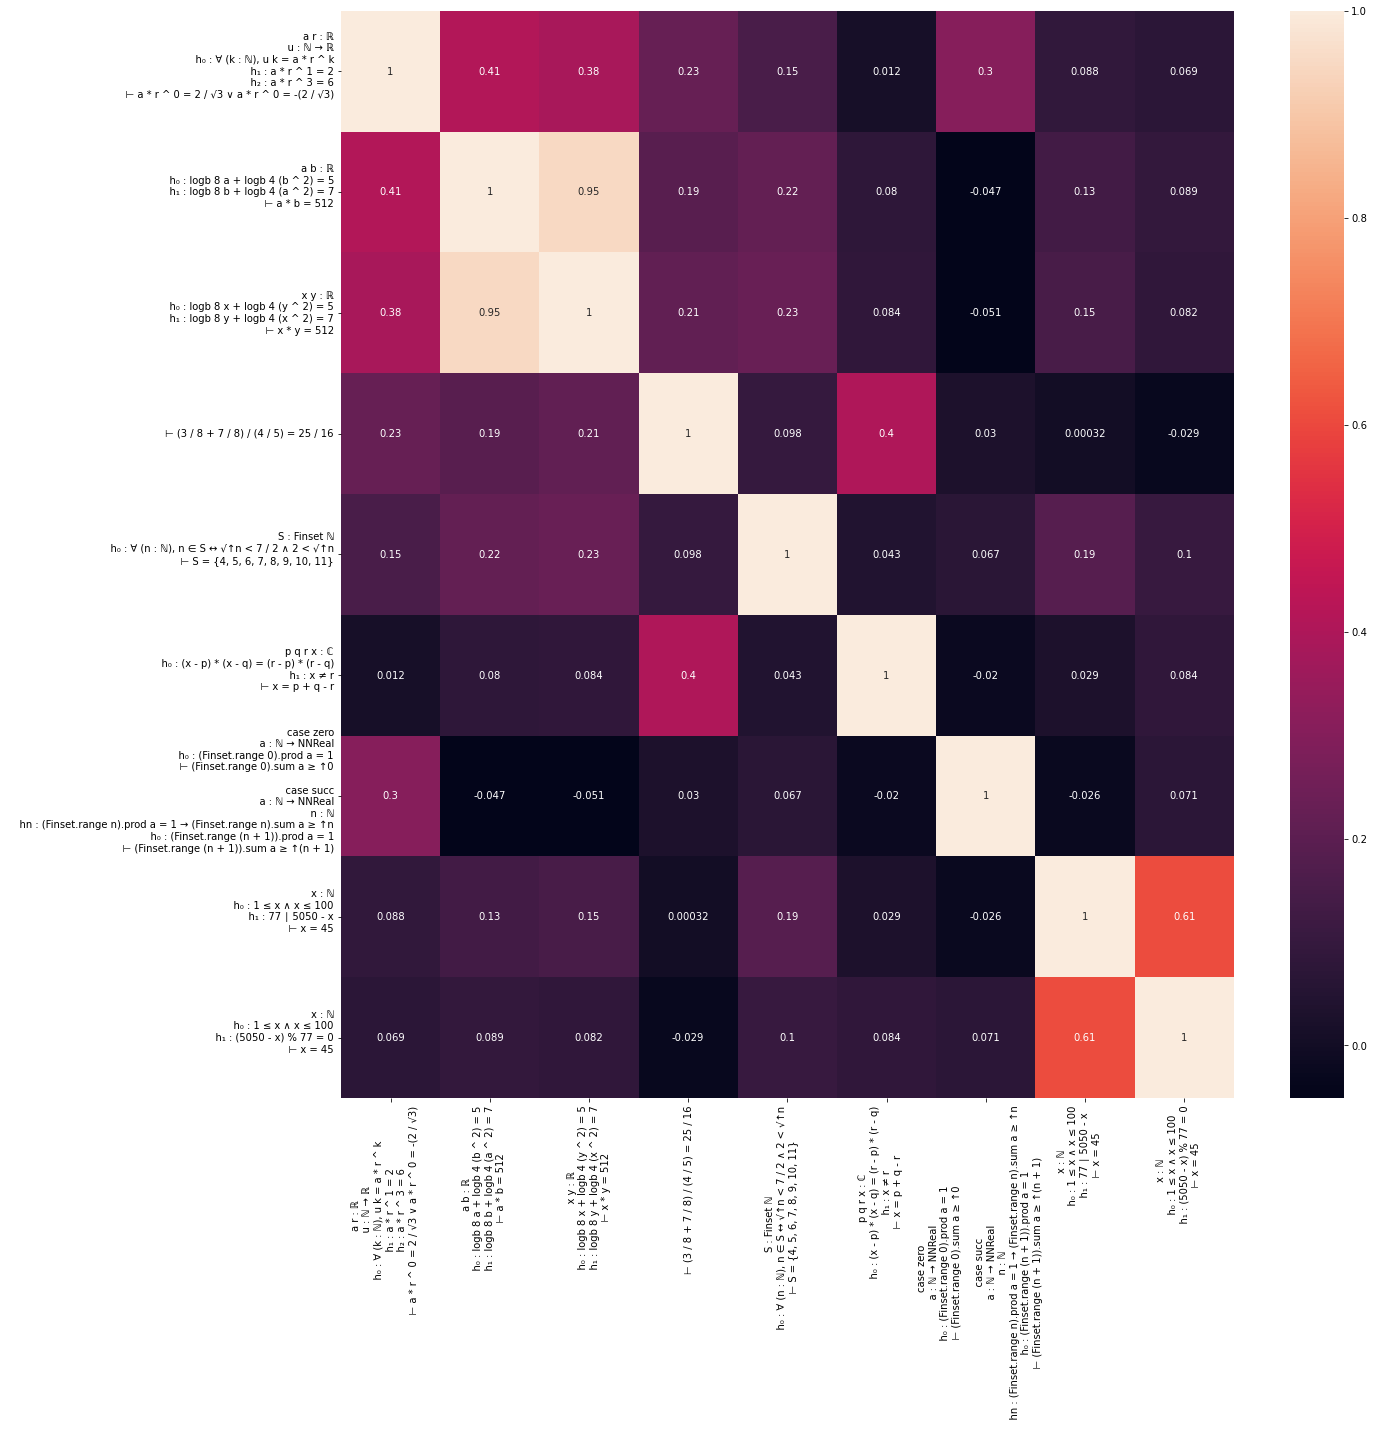

In [25]:
plt.figure(figsize=(20, 20))
sns.heatmap(normalized_all_ts_sim, annot=True, xticklabels=ts_all, yticklabels=ts_all)
plt.show()